In [6]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For data normalization
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt

# For pose detection
from ultralytics import YOLO

# For softmax
from scipy.special import softmax

# For counting classes
from collections import Counter


In [7]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)
    
    return np.array(X), np.array(y)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")


Feature matrix shape: (17662, 34)
Labels array shape: (17662,)


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       458
           1       0.87      0.89      0.88       396
           2       0.92      0.94      0.93       345
           3       0.91      0.88      0.90       424
           4       0.97      0.97      0.97       406
           5       0.93      0.93      0.93       445
           6       0.95      0.93      0.94       504
           7       0.88      0.84      0.86       259
           8       0.88      0.90      0.89       296

    accuracy                           0.91      3533
   macro avg       0.91      0.91      0.91      3533
weighted avg       0.91      0.91      0.91      3533



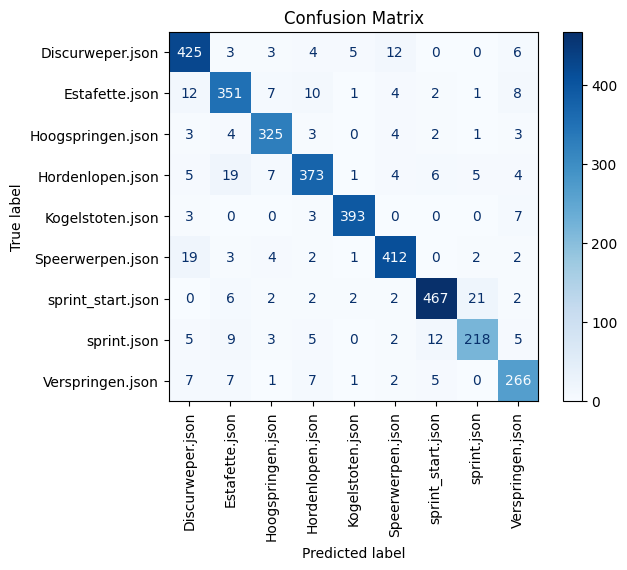

In [8]:
# Initialize the scaler
scaler = MinMaxScaler()

# Split data into training and testing sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(exercise_labels.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [9]:
# Reverse mapping of exercise labels
exercise_labels_inv = {v: k for k, v in exercise_labels.items()}


In [10]:
def extract_keypoints_and_predict(frame, model, clf, scaler):
    # Run the YOLO pose model
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        return None, None  # Skip if no keypoints detected
    
    # Initialize variables to store the keypoints of the largest person
    largest_area = 0
    selected_keypoints = None

    for result in results:
        if result.keypoints is not None and result.boxes is not None and len(result.boxes) > 0:
            keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # x, y coordinates
            bbox = result.boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
            x_min, y_min, x_max, y_max = bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            area = bbox_width * bbox_height

            if area > largest_area:
                largest_area = area
                selected_keypoints = keypoints.flatten()

    if selected_keypoints is None:
        return None, None

    # Check if the number of keypoints matches the expected number
    expected_num_features = scaler.n_features_in_
    if selected_keypoints.size != expected_num_features:
        print(f"Expected {expected_num_features} features, but got {selected_keypoints.size} features")
        return None, None

    # Normalize keypoints
    normalized_keypoints = scaler.transform([selected_keypoints])

    # Predict class and probabilities
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores if not already probabilities
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    return exercise_class[0], exercise_class_proba[0]


In [15]:
import cv2

model = YOLO("yolov8s-pose.pt")  # Replace with your model path if different
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hoogspringen/segment_000001.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")



0: 384x640 1 person, 88.1ms
Speed: 1.9ms preprocess, 88.1ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.9ms
Speed: 0.7ms preprocess, 83.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 81.9ms
Speed: 1.1ms preprocess, 81.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 83.0ms
Speed: 1.0ms preprocess, 83.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.3ms
Speed: 0.6ms preprocess, 79.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 82.1ms
Speed: 0.6ms preprocess, 82.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 157.8ms
Speed: 0.9ms preprocess, 157.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 91.4ms
Speed: 0.6ms preprocess, 91.4ms inference, 0.4ms postprocess per image at shape (1, 3, 

In [16]:
# Output results
print("Class Percentages (Based on Frame Count):")
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

print("\nAverage Probabilities (Softmax Scores):")
for cls, pct in probability_percentages.items():
    print(f"{cls}: {pct:.2f}%")



Class Percentages (Based on Frame Count):
Hoogspringen.json: 99.57%
Hordenlopen.json: 0.43%

Average Probabilities (Softmax Scores):
Discurweper.json: 9.77%
Estafette.json: 9.96%
Hoogspringen.json: 22.03%
Hordenlopen.json: 10.08%
Kogelstoten.json: 9.57%
Speerwerpen.json: 9.53%
sprint_start.json: 9.74%
sprint.json: 9.73%
Verspringen.json: 9.59%
